In [24]:
import os, pickle, random, re
from collections import Counter
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from nltk.translate.bleu_score import corpus_bleu
from sklearn.metrics import precision_score, recall_score, f1_score


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
def find_image_dir():
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
if IMAGE_DIR:
    print(f"Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Flickr30k image directory not found.")


Found images at: /kaggle/input/flickr30k/Images


In [27]:
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, img_name


In [28]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


In [29]:
model_resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model_resnet = nn.Sequential(*list(model_resnet.children())[:-1])  # remove FC layer
model_resnet = nn.DataParallel(model_resnet).to(device)
model_resnet.eval()

DataParallel(
  (module): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [30]:
dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

features_dict = {}
OUTPUT_FILE = 'flickr30k_features.pkl'

with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        imgs = imgs.to(device)
        feats = model_resnet(imgs).view(imgs.size(0), -1)  # (batch_size, 2048)
        for i, name in enumerate(names):
            features_dict[name.split('.')[0]] = feats[i].cpu().numpy()  # remove extension



Extracting Features: 100%|██████████| 249/249 [01:21<00:00,  3.05it/s]


In [31]:
with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)
print(f"Success! {len(features_dict)} images saved to {OUTPUT_FILE}")


Success! 31783 images saved to flickr30k_features.pkl


In [32]:
BASE_DIR = '/kaggle/input/flickr30k'
WORKING_DIR = '/kaggle/working'

In [33]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [34]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, caption = tokens[0].split('.')[0], " ".join(tokens[1:])
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

100%|██████████| 158916/158916 [00:00<00:00, 849806.10it/s]


In [35]:
len(mapping)

31783

In [36]:
import re
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = re.sub(r'[^a-zA-Z ]', '', caption)
            caption = re.sub(r'\s+', ' ', caption)
            caption = 'startseq ' + " ".join([w for w in caption.split() if len(w) > 1]) + ' endseq'
            captions[i] = caption

clean(mapping)

In [37]:
mapping['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [38]:
all_captions = [c for caps in mapping.values() for c in caps]

In [39]:
len(all_captions)

158915

In [40]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [41]:
all_tokens = [c.split() for c in all_captions]
counter = Counter([tok for sent in all_tokens for tok in sent])
vocab = {w:i+1 for i,(w,cnt) in enumerate(counter.items())}  # 0 reserved for <pad>
vocab['<pad>'] = 0
inv_vocab = {i:w for w,i in vocab.items()}

vocab_size = len(vocab)
max_length = max(len(c.split()) for c in all_captions)

def caption_to_seq(caption, vocab):
    return torch.tensor([vocab.get(tok,0) for tok in caption.split()], dtype=torch.long)


In [42]:
image_ids = list(mapping.keys())
random.shuffle(image_ids)
split1 = int(len(image_ids)*0.8)
split2 = int(len(image_ids)*0.9)
train_ids = [k for k in image_ids[:split1] if k in features_dict]
val_ids   = [k for k in image_ids[split1:split2] if k in features_dict]
test_ids  = [k for k in image_ids[split2:] if k in features_dict]


In [60]:
from torchvision import transforms as T
class CaptionDataset(Dataset):
    def __init__(self, image_ids, features_dict, mapping, image_dir, transform=None):
        self.image_ids = image_ids
        self.features_dict = features_dict
        self.mapping = mapping
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        feat = self.features_dict[img_id]
        
        path = os.path.join(self.image_dir, img_id+'.jpg')
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        
        captions = self.mapping[img_id]
        # pick one caption randomly
        cap = random.choice(captions)
        cap_tokens = [vocab[word] for word in cap.lower().split()]  # assuming vocab dict
        
        in_seq = torch.tensor([0] + cap_tokens[:-1])   # startseq
        out_seq = torch.tensor(cap_tokens + [1])      # endseq
        
        return feat, in_seq, out_seq

# Data augmentation transforms
train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
])
val_transform = T.Compose([
    T.Resize((224,224)),
])

In [81]:
class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super().__init__()
        self.fc_features = nn.Linear(feature_dim, hidden_dim)
        self.fc_hidden   = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc_attn = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, features, hidden):
        # Ensure features is 3D: [B, N, feature_dim]
        if features.ndim == 2:
            features = features.unsqueeze(1)  # [B, 1, feature_dim]

        # features: [B, N, feature_dim]
        # hidden: [B, hidden_dim]
        feat_proj = self.fc_features(features)              # [B, N, H]
        hidden_proj = self.fc_hidden(hidden).unsqueeze(1)  # [B, 1, H]
        attn_weights = self.fc_attn(self.relu(feat_proj + hidden_proj))  # [B, N, 1]
        attn_weights = self.softmax(attn_weights.squeeze(2))             # [B, N]
        context = (features * attn_weights.unsqueeze(2)).sum(dim=1)     # [B, feature_dim]
        return context, attn_weights

In [82]:
class CaptionModel(nn.Module):
    def __init__(self, feature_dim, embed_dim, hidden_dim, vocab_size):
        super().__init__()
        self.attn = Attention(feature_dim, hidden_dim)
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim + feature_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, features, captions):
        B, seq_len = captions.size()
        hidden = torch.zeros(1, B, self.gru.hidden_size).to(features.device)
        outputs = []
        embeddings = self.embed(captions)
        
        for t in range(seq_len):
            emb_t = embeddings[:, t, :]  # [B, embed_dim]
            
            # --- Attention ---
            context, _ = self.attn(features, hidden[0])  # context: [B, feature_dim]
            
            # --- Concatenate for GRU input ---
            gru_input = torch.cat([emb_t, context], dim=1).unsqueeze(1)  # [B, 1, embed+feat]
            
            out, hidden = self.gru(gru_input, hidden)
            out = self.fc(self.dropout(out.squeeze(1)))
            outputs.append(out)
        
        outputs = torch.stack(outputs, dim=1)  # [B, seq_len, vocab_size]
        return outputs

In [83]:
import torch.optim as optim
model = CaptionModel(feature_dim=2048, embed_dim=256, hidden_dim=512, vocab_size=vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Early stopping params
patience = 5
best_val_loss = float('inf')
counter = 0


100%|██████████| 398/398 [01:21<00:00,  4.88it/s]


Epoch 1/40 | Train Loss: 5.4185 | Val Loss: 4.5602 | LR: 0.0005


100%|██████████| 398/398 [01:21<00:00,  4.89it/s]


Epoch 2/40 | Train Loss: 4.4845 | Val Loss: 4.1482 | LR: 0.0005


100%|██████████| 398/398 [01:21<00:00,  4.89it/s]


Epoch 3/40 | Train Loss: 4.1736 | Val Loss: 3.9502 | LR: 0.0005


100%|██████████| 398/398 [01:21<00:00,  4.90it/s]


Epoch 4/40 | Train Loss: 4.0177 | Val Loss: 3.8507 | LR: 0.0005


100%|██████████| 398/398 [01:22<00:00,  4.84it/s]


Epoch 5/40 | Train Loss: 3.8869 | Val Loss: 3.7825 | LR: 0.0005


100%|██████████| 398/398 [01:21<00:00,  4.87it/s]


Epoch 6/40 | Train Loss: 3.7640 | Val Loss: 3.6902 | LR: 0.00025


100%|██████████| 398/398 [01:21<00:00,  4.89it/s]


Epoch 7/40 | Train Loss: 3.7277 | Val Loss: 3.6766 | LR: 0.00025


100%|██████████| 398/398 [01:21<00:00,  4.88it/s]


Epoch 8/40 | Train Loss: 3.6791 | Val Loss: 3.6601 | LR: 0.00025


100%|██████████| 398/398 [01:21<00:00,  4.88it/s]


Epoch 9/40 | Train Loss: 3.6392 | Val Loss: 3.6698 | LR: 0.00025


100%|██████████| 398/398 [01:21<00:00,  4.90it/s]


Epoch 10/40 | Train Loss: 3.5981 | Val Loss: 3.6387 | LR: 0.00025


100%|██████████| 398/398 [01:21<00:00,  4.89it/s]


Epoch 11/40 | Train Loss: 3.5482 | Val Loss: 3.6251 | LR: 0.000125


100%|██████████| 398/398 [01:21<00:00,  4.89it/s]


Epoch 12/40 | Train Loss: 3.5228 | Val Loss: 3.5644 | LR: 0.000125


100%|██████████| 398/398 [01:21<00:00,  4.89it/s]


Epoch 13/40 | Train Loss: 3.5090 | Val Loss: 3.6015 | LR: 0.000125


100%|██████████| 398/398 [01:21<00:00,  4.89it/s]


Epoch 14/40 | Train Loss: 3.5087 | Val Loss: 3.5686 | LR: 0.000125


100%|██████████| 398/398 [01:21<00:00,  4.89it/s]


Epoch 15/40 | Train Loss: 3.4808 | Val Loss: 3.5749 | LR: 0.000125


100%|██████████| 398/398 [01:21<00:00,  4.90it/s]


Epoch 16/40 | Train Loss: 3.4509 | Val Loss: 3.5689 | LR: 6.25e-05


100%|██████████| 398/398 [01:21<00:00,  4.88it/s]


Epoch 17/40 | Train Loss: 3.4506 | Val Loss: 3.5173 | LR: 6.25e-05


100%|██████████| 398/398 [01:21<00:00,  4.89it/s]


Epoch 18/40 | Train Loss: 3.4232 | Val Loss: 3.5343 | LR: 6.25e-05


100%|██████████| 398/398 [01:21<00:00,  4.88it/s]


Epoch 19/40 | Train Loss: 3.4208 | Val Loss: 3.5370 | LR: 6.25e-05


100%|██████████| 398/398 [01:21<00:00,  4.89it/s]


Epoch 20/40 | Train Loss: 3.4312 | Val Loss: 3.5233 | LR: 6.25e-05


100%|██████████| 398/398 [01:21<00:00,  4.88it/s]


Epoch 21/40 | Train Loss: 3.4168 | Val Loss: 3.5550 | LR: 3.125e-05


100%|██████████| 398/398 [01:21<00:00,  4.90it/s]


Epoch 22/40 | Train Loss: 3.4048 | Val Loss: 3.5307 | LR: 3.125e-05
Early stopping triggered


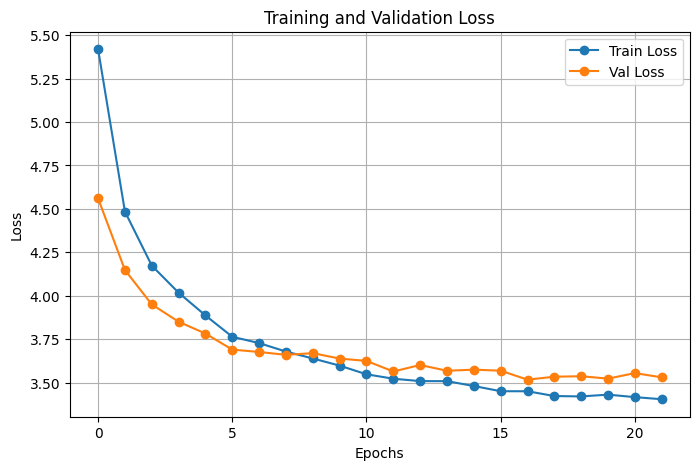

In [85]:
import matplotlib.pyplot as plt

# Training loop (aapka existing code)
epochs = 40
train_losses, val_losses = [], []
best_val_loss = float('inf')
counter = 0
patience = 5  # jitni epochs ke liye val_loss improve na ho, early stop

for ep in range(epochs):
    model.train()
    total_loss = 0
    for feats, in_seq, out_seq in tqdm(train_loader):
        feats, in_seq, out_seq = feats.to(device), in_seq.to(device), out_seq.to(device)
        optimizer.zero_grad()
        outputs = model(feats, in_seq)
        loss = criterion(outputs.view(-1, vocab_size), out_seq.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for feats, in_seq, out_seq in val_loader:
            feats, in_seq, out_seq = feats.to(device), in_seq.to(device), out_seq.to(device)
            outputs = model(feats, in_seq)
            loss = criterion(outputs.view(-1, vocab_size), out_seq.view(-1))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {ep+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {scheduler.get_last_lr()[0]}")
    
    # Scheduler step
    scheduler.step()
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# ====== PLOT LOSS ======
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
def idx_to_word(index):
    return inv_vocab.get(index, None)

In [90]:
def greedy_caption(feature, max_len=20):
    model.eval()
    
    # --- Convert numpy to tensor if needed ---
    if isinstance(feature, np.ndarray):
        feature = torch.tensor(feature, dtype=torch.float32)
    
    if feature.ndim == 2:
        feature = feature.unsqueeze(0)  # Ensure batch dimension
    feature = feature.to(device)
    
    caption = [vocab['startseq']]
    
    with torch.no_grad():
        for _ in range(max_len):
            seq = torch.tensor(caption, dtype=torch.long).unsqueeze(0).to(device)
            out = model(feature, seq)
            next_word = out[0,-1].argmax().item()
            if next_word == vocab['endseq']:
                break
            caption.append(next_word)
    
    words = [idx_to_word(idx) for idx in caption[1:]]
    return " ".join([w for w in words if w is not None])




In [91]:
def beam_search_caption(feature, beam_width=3, max_len=20):
    model.eval()
    
    if isinstance(feature, np.ndarray):
        feature = torch.tensor(feature, dtype=torch.float32)
    
    if feature.ndim == 2:
        feature = feature.unsqueeze(0)
    feature = feature.to(device)
    
    sequences = [(0.0, [vocab['startseq']])]
    
    with torch.no_grad():
        for _ in range(max_len):
            all_candidates = []
            for score, seq in sequences:
                if seq[-1] == vocab['endseq']:
                    all_candidates.append((score, seq))
                    continue

                seq_tensor = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)
                out = model(feature, seq_tensor)
                probs = torch.log_softmax(out[0, -1], dim=-1)
                
                top_probs, top_idx = probs.topk(beam_width)
                
                for i in range(beam_width):
                    candidate = (score + top_probs[i].item(), seq + [top_idx[i].item()])
                    all_candidates.append(candidate)
            
            sequences = sorted(all_candidates, key=lambda x: x[0], reverse=True)[:beam_width]
            
            if all(seq[-1] == vocab['endseq'] for _, seq in sequences):
                break
    
    best_seq = sequences[0][1]
    words = [idx_to_word(idx) for idx in best_seq[1:]]
    return " ".join([w for w in words if w is not None])

In [92]:
test_actual, test_pred = [], []
for img_id in tqdm(test_ids):
    captions = mapping[img_id]
    pred = greedy_caption(features_dict[img_id])
    test_pred.append(pred.split())
    test_actual.append([cap.split() for cap in captions])

bleu1 = corpus_bleu(test_actual, test_pred, weights=(1,0,0,0))
bleu2 = corpus_bleu(test_actual, test_pred, weights=(0.5,0.5,0,0))
bleu3 = corpus_bleu(test_actual, test_pred, weights=(0.33,0.33,0.33,0))
bleu4 = corpus_bleu(test_actual, test_pred, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1:{bleu1:.4f} BLEU-2:{bleu2:.4f} BLEU-3:{bleu3:.4f} BLEU-4:{bleu4:.4f}")

from sklearn.metrics import precision_score, recall_score, f1_score

flat_actual, flat_pred = [], []

for img_id in test_ids:
    ref = mapping[img_id][0].split()  # take first reference
    pred = greedy_caption(features_dict[img_id]).split()
    # Truncate/pad both sequences to same length
    min_len = min(len(ref), len(pred))
    flat_actual.extend(ref[:min_len])
    flat_pred.extend(pred[:min_len])

precision = precision_score(flat_actual, flat_pred, average='micro', zero_division=0)
recall = recall_score(flat_actual, flat_pred, average='micro', zero_division=0)
f1 = f1_score(flat_actual, flat_pred, average='micro', zero_division=0)

print(f"Token-level Precision:{precision:.4f} Recall:{recall:.4f} F1:{f1:.4f}")

100%|██████████| 3179/3179 [01:55<00:00, 27.53it/s]


BLEU-1:0.5135 BLEU-2:0.3205 BLEU-3:0.2000 BLEU-4:0.1177
Token-level Precision:0.0207 Recall:0.0207 F1:0.0207


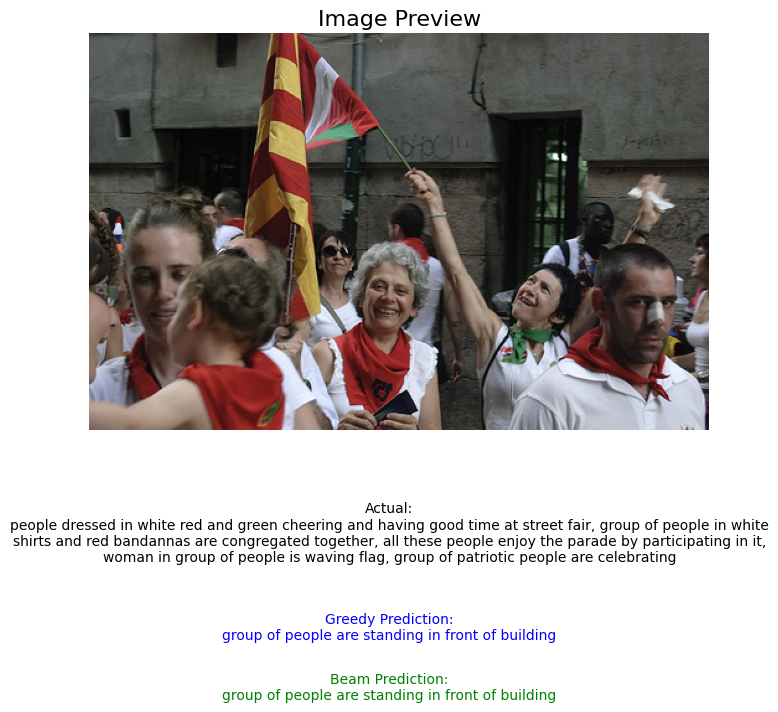

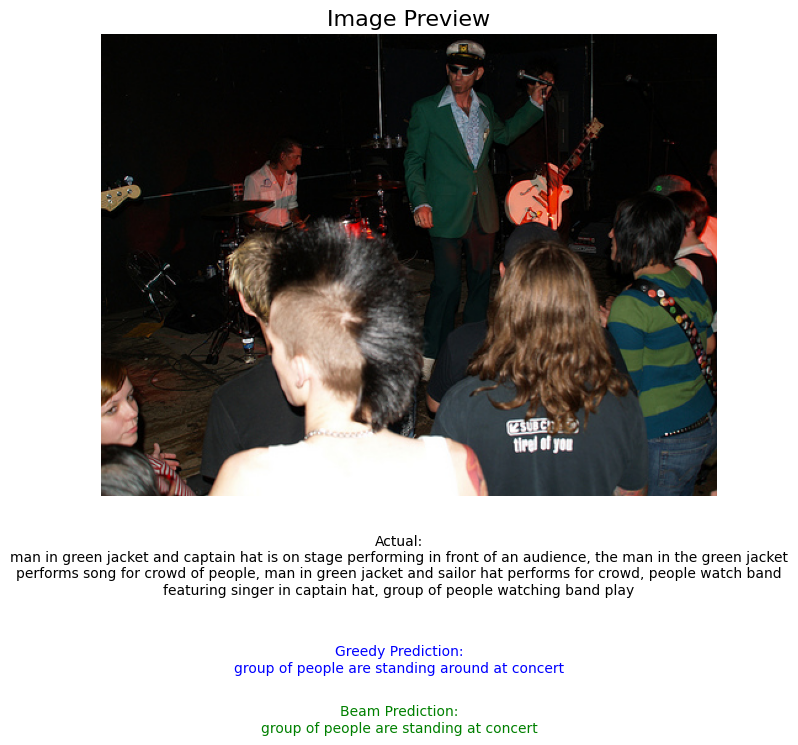

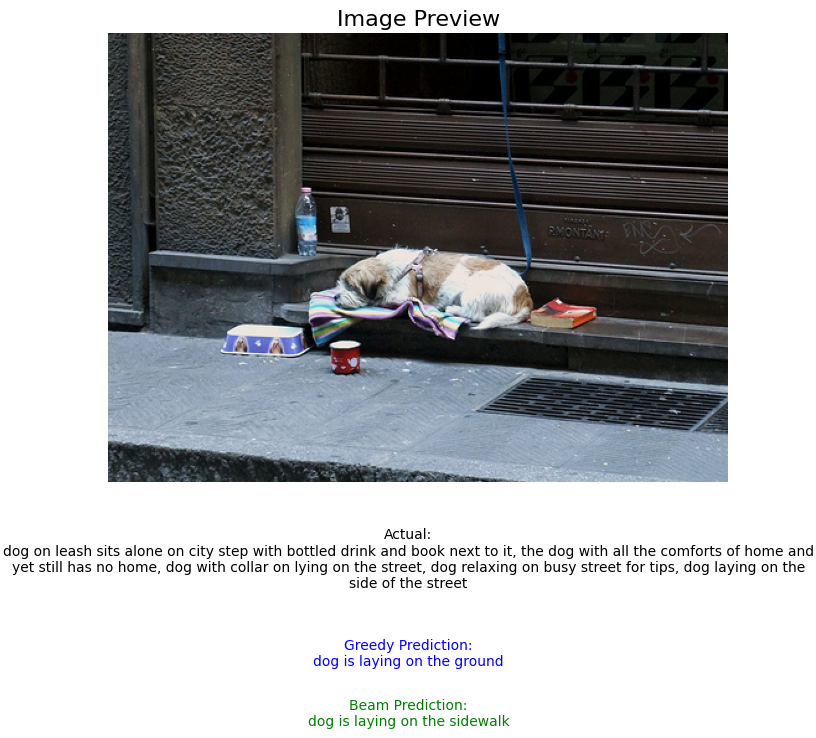

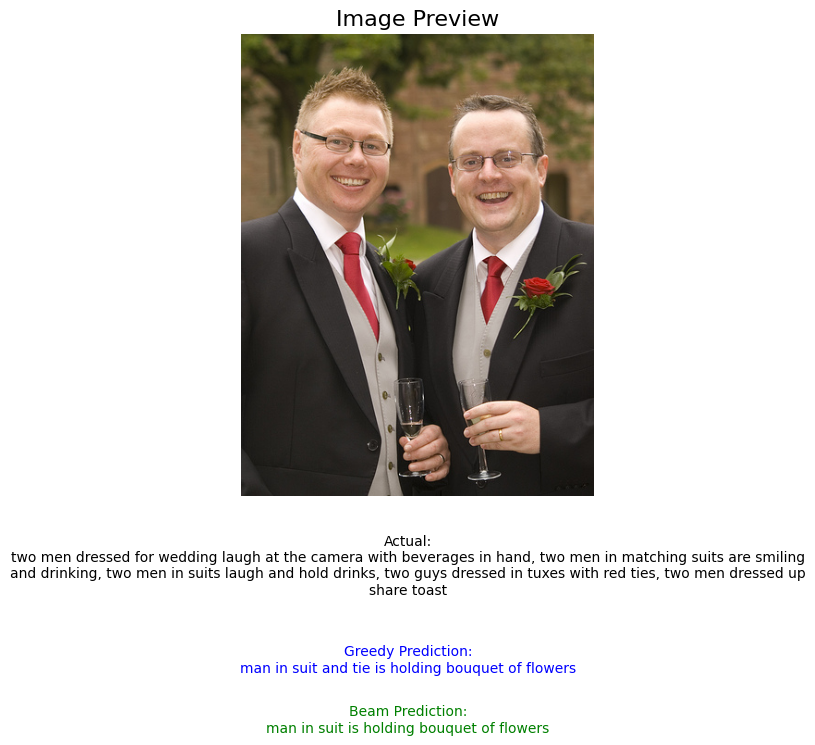

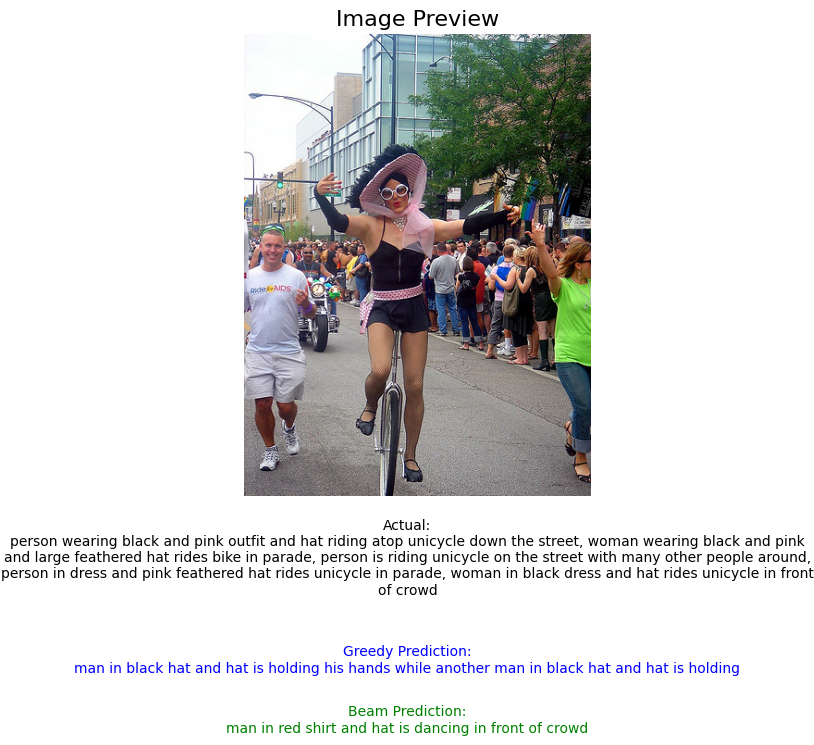

In [93]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import os

# Function to clean captions
def clean_caption(caption):
    caption = caption.replace('startseq', '').replace('endseq', '')
    return caption.strip()

# Pick 5 random test images
sample_ids = random.sample(test_ids, 5)

for img_id in sample_ids:
    # Load image
    path = os.path.join(IMAGE_DIR, img_id + '.jpg')
    img = Image.open(path)

    # Generate captions and clean them
    greedy_cap = clean_caption(greedy_caption(features_dict[img_id]))
    beam_cap   = clean_caption(beam_search_caption(features_dict[img_id]))

    # Plot image
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image Preview", fontsize=16)

    # Show captions below image
    plt.figtext(0.5, -0.05, f"Actual:\n{', '.join([clean_caption(c) for c in mapping[img_id]])}", 
                ha="center", fontsize=10, wrap=True)
    plt.figtext(0.5, -0.18, f"Greedy Prediction:\n{greedy_cap}", 
                ha="center", fontsize=10, wrap=True, color='blue')
    plt.figtext(0.5, -0.28, f"Beam Prediction:\n{beam_cap}", 
                ha="center", fontsize=10, wrap=True, color='green')

    plt.show()

In [95]:
import gradio as gr
from PIL import Image
import torch
import torchvision.transforms as T

# --- Transform for uploaded image ---
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

# --- Captioning function for Gradio ---
def gradio_caption_upload(img, beam_width=3):
    # Convert PIL to tensor
    img_tensor = transform(img).unsqueeze(0).to(device)  # [1,3,224,224]

    # Extract features using pre-trained ResNet
    with torch.no_grad():
        feat = model_resnet(img_tensor).flatten(1)
    # Generate captions
    greedy_cap = greedy_caption(feat)
    beam_cap   = beam_search_caption(feat, beam_width)

    # Clean captions
    def clean_caption(c):
        return c.replace('startseq','').replace('endseq','').strip()

    return clean_caption(greedy_cap), clean_caption(beam_cap)

# --- Launch Gradio interface ---
iface = gr.Interface(
    fn=gradio_caption_upload,
    inputs=[
        gr.Image(type='pil', label="Upload Image"),
        gr.Slider(minimum=1, maximum=5, step=1, value=3, label="Beam Width")
    ],
    outputs=[
        gr.Textbox(label="Greedy Caption"),
        gr.Textbox(label="Beam Search Caption")
    ],
    title="Image Captioning Demo",
    description="Upload an image to generate captions using your trained model."
)

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7866
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://2a47a11b13c4fa373e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7866 <> https://2a47a11b13c4fa373e.gradio.live
